# CSC413: Final Project

In [1]:
import numpy as np
import math
import torch
import torchvision
import matplotlib

from dynaopt import DynamicOptimizer

%matplotlib inline

## Convolutional Neural Network

In [2]:
import torchvision

batch_size = 100
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

if torch.cuda.is_available():
    print("Using GPUs")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # for mac
    print("Using GPUs (mac)")
    device = torch.device('mps')
else:
    device = torch.device("cpu")

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 32) # in_channels, out_channels, kernel_size
        self.pool1 = torch.nn.MaxPool2d(1)      # kernel_size
        self.conv2 = torch.nn.Conv2d(16, 32, 1)
        self.pool2 = torch.nn.MaxPool2d(1)
        self.fc1 = torch.nn.Linear(32, 128)     # in_features, out_features
        self.fc2 = torch.nn.Linear(128, 10)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        # print("After conv1: {}".format(x.shape))
        x = self.pool1(x)
        # print("After pool1: {}".format(x.shape))
        x = self.conv2(x)
        # print("After conv2: {}".format(x.shape))
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = ConvNet()
print(torch.__version__)
model.to(device)


Using GPUs (mac)
2.0.0


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(32, 32), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = DynamicOptimizer(model.parameters(), lr=0.001, debug=True)

### Train

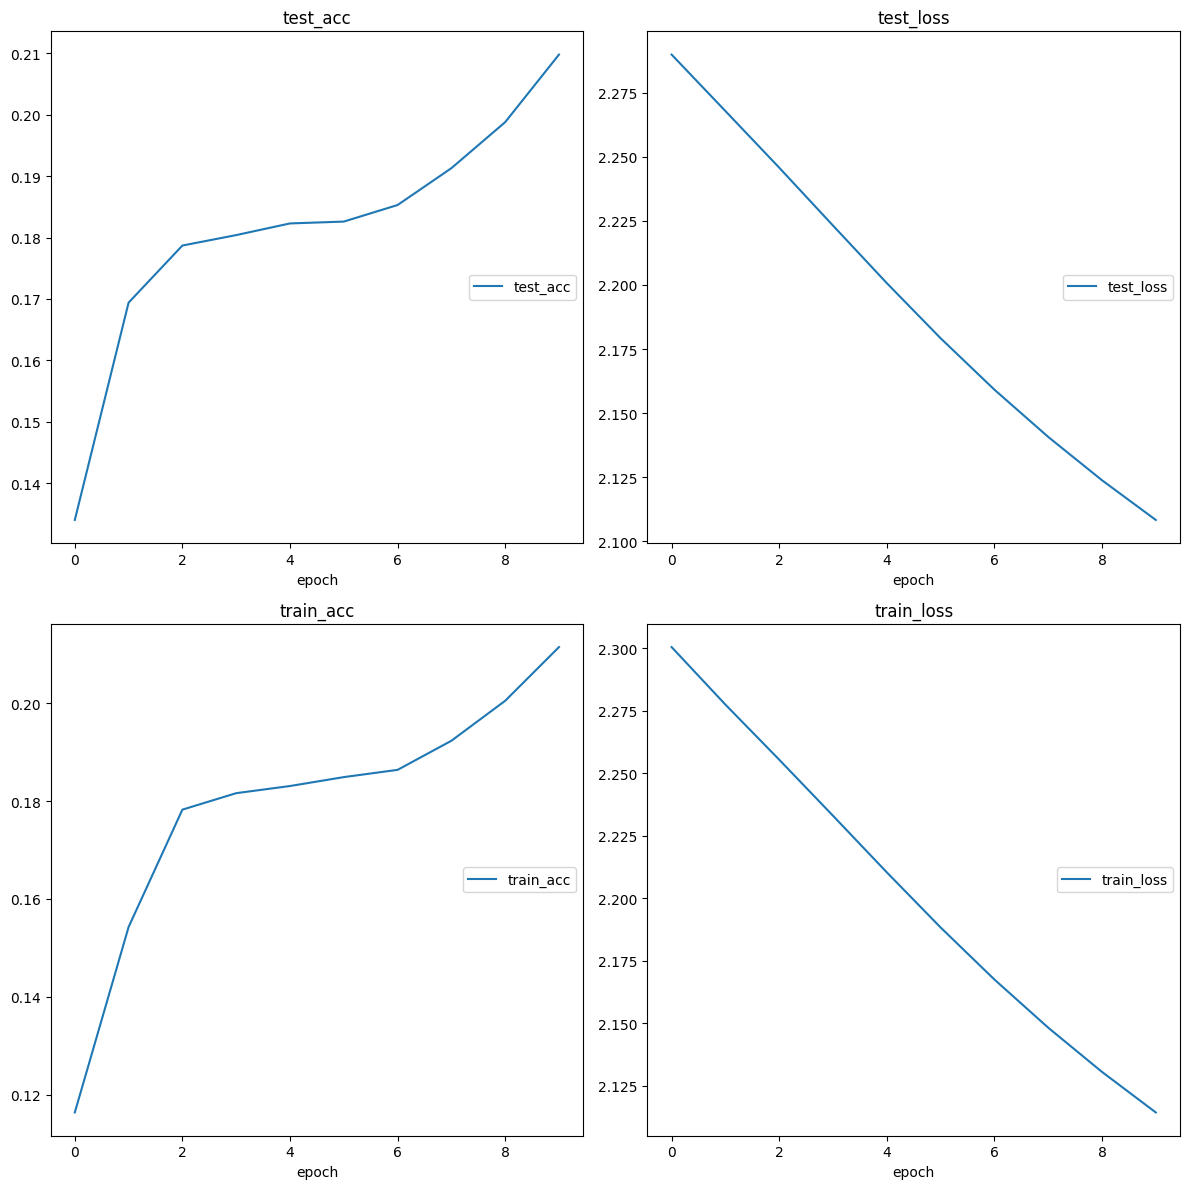

test_acc
	test_acc         	 (min:    0.134, max:    0.210, cur:    0.210)
test_loss
	test_loss        	 (min:    2.108, max:    2.290, cur:    2.108)
train_acc
	train_acc        	 (min:    0.116, max:    0.211, cur:    0.211)
train_loss
	train_loss       	 (min:    2.114, max:    2.300, cur:    2.114)


In [5]:
epochs = 10

liveloss = PlotLosses()
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch, epochs - 1))
    print("-" * 30)
    
    epoch_loss = {"train": 0.0, "test": 0.0}
    epoch_acc = {"train": 0.0, "test": 0.0}
    
    running_loss = {"train": 0.0, "test": 0.0}
    running_corrects = {"train": 0, "test": 0}
    
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
        else:
            model.train(False)
        
        for data in data_loaders[phase]:
            inputs, labels = data
            # print(inputs.shape)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad() # clear all gradients
            
            outputs = model(inputs) # batch_size x num_classes
            _, preds = torch.max(outputs.data, 1) # values, indices
            loss = loss_fn(outputs, labels)
            
            if phase == "train":
                loss.backward()  # compute gradients
                def closure():
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    return loss
                optimizer.step(closure) # update weights/biases
               
            running_loss[phase] += loss.data.item() * inputs.size(0)
            running_corrects[phase] += torch.sum(preds == labels.data).item()
        
        epoch_loss[phase] = running_loss[phase] / dataset_sizes[phase]
        epoch_acc[phase] =  running_corrects[phase] / dataset_sizes[phase]

    # Visualize the loss and accuracy values.
    liveloss.update({
        'train_loss': epoch_loss["train"],
        'test_loss': epoch_loss["test"],
        'train_acc': epoch_acc["train"],
        'test_acc': epoch_acc["test"],
    })
    liveloss.draw() 

    #40 ish works